<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/feature_extractor_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# copy the filters from ex7
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib
from skimage import feature, io, color

In [1]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_data_reduced.csv'
column_names = ['path', 'index', 'label']
df_train = pd.read_csv(csv_file_path, names=column_names)
df_train = df_train.iloc[1:]
df_train = df_train.reset_index(drop=True)

In [105]:
# preprocess and pipeline

def grayscale_preprocessing(img):
  if np.max(img)>1:
    img = img.astype(np.float32)/255.0
  im_gray = np.mean(img, axis=2)
  return im_gray

def bilateral_preprocessing(img, ksize, sigmX, sigmY):
  bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
  return bilateral_filtered_image

def high_pass_preprocessing(img, ksize, sig):
  low_pass = cv2.GaussianBlur(img, ksize, 0)
  high_pass = img - low_pass
  return high_pass

def sobel_preprocessing(img, ksize):
  sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize) # Find x and y gradients
  sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
  magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
  magnitude = magnitude / np.max(magnitude) # normalize
  return magnitude

def gaussian_blur_preprocessing(img, ksize, sigma):
  blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
  return blurred_im

def canny_filter(img, high_threshold, low_threshold):
  # ensure the image is normalized to the range [0, 1]
  img = img / np.max(img)
  # scale the image to the range [0, 255] and convert to 8-bit
  img_8u = np.uint8(img * 255)
  # threshold the image and get the interesting points
  # The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
  # The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
  # By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

  im_threshold = cv2.Canny(image=img_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
  im_threshold = im_threshold / np.max(im_threshold) # normalize
  return im_threshold

def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]


def histogram_clipping(img, threshold_value):
  clipped_image = img.copy()
  # before
  # draw_histogram_gray(clipped_image)
  clipped_image[img < threshold_value/255.0] = 0
  # Normalize the clipped_image to 0-255 for proper histogram visualization
  normalized_clipped_image = cv2.normalize(clipped_image, None, alpha=0, beta=255,
                                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  # draw_histogram_gray(clipped_image)
  return normalized_clipped_image

def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
  block_norm = 'L1'  # Block normalization method
  # orientations = 9   # Number of orientation bins
  # pixels_per_cell = (8, 8)  # Size of the cell
  # cells_per_block = (3, 3)  # Size of the block

  # Compute the HOG features
  hog_features, hog_image = feature.hog(img_gray,
                                        orientations=orientations,
                                        pixels_per_cell=pixels_per_cell,
                                        cells_per_block=cells_per_block,
                                        block_norm=block_norm,
                                        visualize=True)
  return hog_features, hog_image

def preprocess_1(df):
  image_dir = df['path'] # ignore index
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_sobel = sobel_preprocessing(im_bilateral, 31)
    im_canny = canny_filter(im_blurred, 70, 0)
    im_cropped = crop_center(im_canny, 252, 252)
    im_flattened = im_cropped.flatten()
    preprocessed_list.append(im_flattened)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed

def preprocess_2(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 240, 240)
    hog_feature, hog_image = hog(im_cropped) #(63504,)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(hog_feature)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed


def preprocess_resnet(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 224, 224)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(im_cropped)

  return preprocessed_list


def preprocess_resnet_nopreprocess(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))
    preprocessed_list.append(im)
  return preprocessed_list


In [4]:
def display_img_colorbar(img):
  # display the points
  fig, ax = plt.subplots(figsize=(8, 6))
  im_ax = plt.imshow(img, cmap='gray')
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im_ax, cax=cax)
  plt.show()

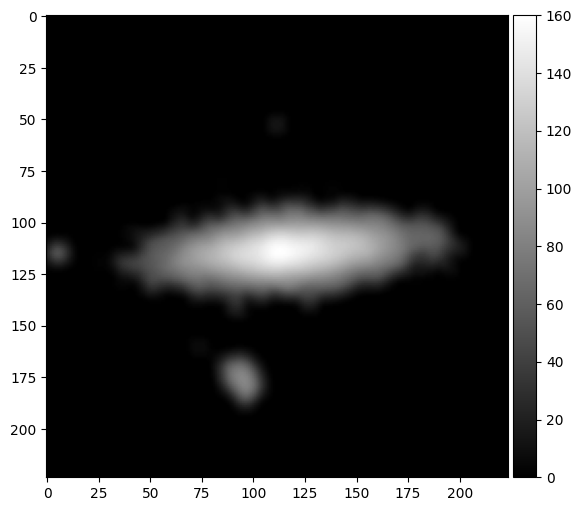

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = preprocess_resnet(df_train[:10])[9]
display_img_colorbar(img)

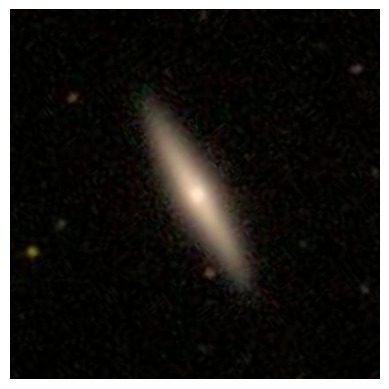

In [102]:
# print out the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = Image.open(df_train['path'][0])
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [46]:
images_list = preprocess_resnet(df_train)

In [119]:
images_list_nopreprocess = preprocess_resnet_nopreprocess(df_train)

In [85]:
import torch
import torchvision.models as models

# load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# remove the classifier on top of resnet
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
# freeze the parameters of the feature extractor
for param in resnet.parameters():
    param.requires_grad = False
# Print the modified ResNet architecture

print(resnet)

# move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [218]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# data loader
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return img

# transformations to be applied to the images
transform = transforms.Compose([
    # crop the image to shape of 224,224 in preprocess stage
    transforms.Resize(256),  # Step 1: Resize to 256x256
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# function to preprocess an image
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = Image.fromarray(img)
        processed_image = transform(img).unsqueeze(0)  # Add batch dimension
        processed_images.append(processed_image)
    return processed_images


custom_dataset = CustomDataset(images_list_nopreprocess, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features = resnet(batch.to(device))
        features_list.append(features)

# Concatenate features from all batches
features = torch.cat(features_list, dim=0)

print(features.shape)

torch.Size([2000, 2048, 1, 1])


In [219]:
import pandas as pd

features = features.cpu()
# reshape it to 2000,2048
reshaped_features = features.squeeze().numpy()
reshaped_features = reshaped_features.reshape(reshaped_features.shape[0], -1)

# Convert to DataFrame
df_features = pd.DataFrame(reshaped_features)

# Display the DataFrame
df_features.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.359366,0.829289,0.351126,0.783453,0.320450,0.351969,0.692546,0.581185,0.266373,0.597713,...,0.286002,0.742273,0.298849,0.258116,0.405573,0.168348,0.408478,0.329045,0.381625,0.247085
1,0.204744,0.901514,0.363921,0.390335,0.763405,0.305313,0.723293,0.665273,0.196539,0.082321,...,0.804578,0.093171,0.256398,0.207099,0.490894,0.240808,0.271352,0.281761,0.063480,0.240311
2,0.338716,0.419582,0.545802,0.245139,0.369690,0.302925,0.477242,0.087587,0.136689,0.186300,...,0.272444,0.311556,0.478063,0.109616,0.268340,0.030048,0.049269,0.454125,0.262713,0.020325


In [220]:
df_features.shape

(2000, 2048)

In [89]:
df_features.to_csv('/content/drive/MyDrive/galaxy_zoo/df_train_reduced_resnet', index=False)

In [123]:
from sklearn.decomposition import PCA

def pick_top_feature_pca_train(feature_matrix, top_components):
#pick up top 100 features by PCA
  pca = PCA(n_components=500)
  pca.fit(feature_matrix)
  principal_components = pca.transform(feature_matrix)
  top_components_matrix = principal_components[:, :top_components]

  plt.figure(figsize=(8, 4))
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('Number of PCA components')
  plt.ylabel('Cumulative explained variance')
  plt.title('Explained Variance vs Number of PCA Components')
  plt.grid(True)
  plt.show()
  # Extract the top n components
  return top_components_matrix, pca

# use the pca embedding from train and process the val and test
def pick_top_feature_pca_val_test(pca_train, feature_matrix, top_components: int):
  principal_components = pca_train.transform(feature_matrix)
  top_components_matrix = principal_components[:, :top_components]
  return top_components_matrix

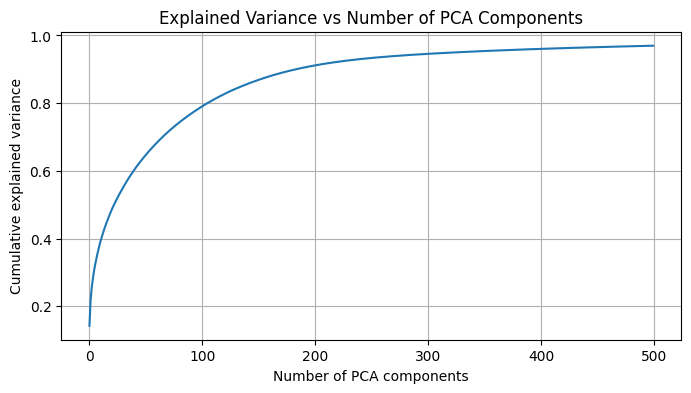

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.976145,-0.210586,2.963224,3.004897,2.955921,0.898746,1.838582,-2.310728,0.083899,0.046703,...,-0.060405,1.473444,-0.808433,0.420207,-0.426119,0.580763,0.068467,0.723658,0.706800,-0.894051
1,-4.734610,1.820235,-3.011337,-0.206974,0.930395,0.776206,0.894764,-0.835294,-1.831485,0.650642,...,-0.206047,-0.038367,0.410777,0.042744,-0.493143,1.304344,0.456110,0.455018,0.609983,0.000632
2,-4.089974,-2.151891,-0.242409,2.772429,0.719886,-1.159400,-1.128802,0.598922,-0.280850,-0.435652,...,0.791741,-0.531498,-0.914504,-0.609056,0.757602,0.353461,-0.302934,-0.279922,-0.826904,0.181991


In [221]:
train_features = df_features.values
top_components = 100
pca_train_features, pca_train_resnet = pick_top_feature_pca_train(train_features, top_components)

# Convert PCA transformed features to DataFrame
df_top_pca_resnet = pd.DataFrame(pca_train_features)
df_top_pca_resnet.head(3)

In [181]:
# feature normarlization since we only pick up top 200. z score normalization

from sklearn.preprocessing import StandardScaler

def feature_normalization(df_feature):
  scaler = StandardScaler()
  normalized_features = scaler.fit_transform(df_feature.values)
  df_normalized = pd.DataFrame(normalized_features, columns=df_feature.columns)
  return df_normalized

In [238]:
# df_top_pca_resnet_pca_normalized = feature_normalization(df_top_pca_resnet)
# df_top_pca_resnet_pca_normalized.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.443798,-0.065420,1.283421,1.595181,1.654093,0.557560,1.204781,-1.582943,0.059140,0.034165,...,-0.105973,2.599735,-1.430413,0.746898,-0.761712,1.039220,0.123927,1.321036,1.295072,-1.645378
1,-1.063287,0.565465,-1.304259,-0.109874,0.520636,0.481539,0.586319,-0.572211,-1.290995,0.475970,...,-0.361478,-0.067694,0.726815,0.075975,-0.881522,2.334001,0.825577,0.830633,1.117675,0.001164
2,-0.918517,-0.668496,-0.104991,1.471772,0.402838,-0.719263,-0.739678,0.410286,-0.197968,-0.318697,...,1.388986,-0.937772,-1.618092,-1.082569,1.354259,0.632485,-0.548322,-0.510997,-1.515142,0.334931
3,1.227683,1.215443,0.061779,-2.104933,-1.779537,-0.145422,0.723707,2.203770,1.198011,0.098739,...,2.307678,0.616949,3.630100,2.031530,1.548349,-1.109480,-0.045200,-0.586843,0.072841,-0.530372
4,0.445997,-1.309635,-1.511052,-1.434925,1.577058,-0.125910,-0.795444,-0.201363,-0.423689,-1.083194,...,-0.590077,-1.363179,-0.321915,-1.206287,-0.466705,0.143824,-0.646375,0.078215,-0.938691,0.472938


In [243]:
#skip normalization
df_top_pca_resnet_pca_normalized = df_top_pca_resnet

In [205]:
df_top_pca_resnet_pca_normalized.to_csv('/content/drive/MyDrive/galaxy_zoo/df_train_reduced_resnet_pca20', index=False)

In [244]:
df_train_resnet = pd.concat([df_train, df_top_pca_resnet_pca_normalized], axis=1)
print(df_train_resnet.shape)

(2000, 103)


classifier LDA + logistic

In [240]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix

X = df_train_resnet.drop(['path', 'index', 'label'], axis=1)  # features
y = df_train_resnet['label'] # label

# split the data here (need to circle back and use the actual testing data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LDA to reduce the dimension to number of class - 1
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)

#logistic regression as the classifer in the space of LDA space
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)

# Logistic Regression with L1 regularization
# [0.001, 0.01, 0.1, 1]
classifier_l1 = LogisticRegression(penalty='l1', C=1 , solver='liblinear')
classifier_l1.fit(X_train_lda, y_train)

# Logistic Regression with L2 regularization
# C [0.1, 1, 10, 100]
classifier_l2 = LogisticRegression(penalty='l2', C=100)
classifier_l2.fit(X_train_lda, y_train)

# transform the test data to the LDA feature space and make predictions
X_test_lda = lda.transform(X_test)
y_pred = classifier.predict(X_test_lda)

# evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print("validation accuracy:", accuracy)

# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Assess Overfitting
# To assess overfitting, you can compare the performance on the training set and test set.
# If the model performs significantly better on the training set compared to the test set, it may be overfitting.
train_accuracy = accuracy_score(y_train, classifier.predict(X_train_lda))
print("Training Accuracy:", train_accuracy)
train_accuracy_l1 = accuracy_score(y_train, classifier_l1.predict(X_train_lda))
train_accuracy_l2 = accuracy_score(y_train, classifier_l2.predict(X_train_lda))

print("Training Accuracy with L1 Regularization:", train_accuracy_l1)
print("Training Accuracy with L2 Regularization:", train_accuracy_l2)

# neither ways work (with preprocess or without preprocess)

validation accuracy: 0.0575
Confusion Matrix:
[[ 3 20 20 24 16]
 [13  7 24 18 15]
 [14 24  4 17 23]
 [16 10 21  5 16]
 [19 16 26 25  4]]
Training Accuracy: 0.276875
Training Accuracy with L1 Regularization: 0.28
Training Accuracy with L2 Regularization: 0.276875


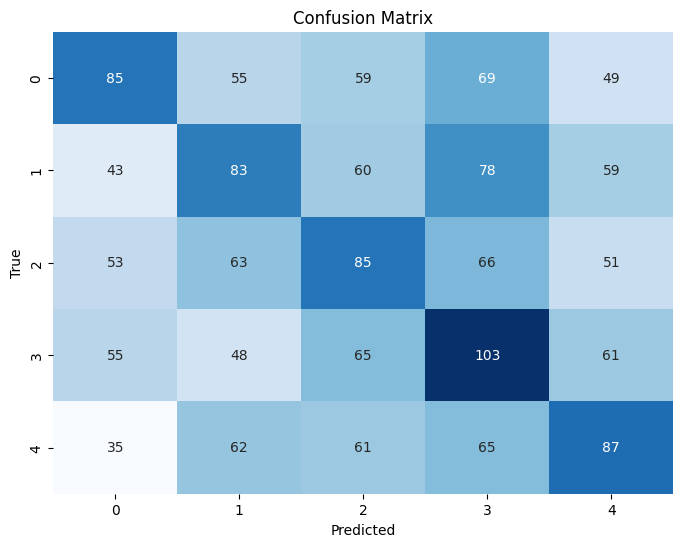

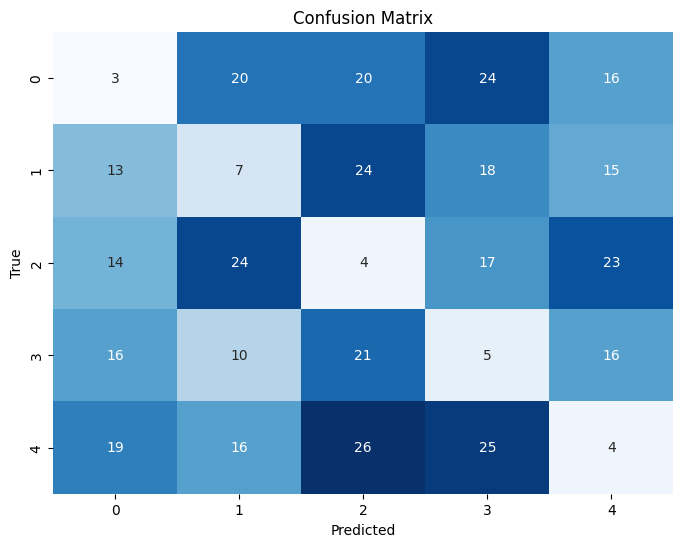

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_matrix_val = confusion_matrix(y_test, y_pred)
conf_matrix_train = confusion_matrix(y_train, classifier.predict(X_train_lda))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Try SVM

In [245]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = df_train_resnet.drop(['path', 'index', 'label'], axis=1)  # features
y = df_train_resnet['label'] # label
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=52)

# train the SVM classifier
# C is a hyperparameter that controls the trade-off between maximizing the margin and minimizing the classification error.
# C represents the inverse of the regularization strength—smaller, C implies more regularization, larger, C implies less regularization
# poly, rbf, linear
svm_classifier = SVC(kernel='rbf', C=1)
svm_classifier.fit(X_train, y_train)
cv_scores = cross_val_score(svm_classifier, X, y, cv=5)

print("cross-val accuracy:", cv_scores.mean())

# training accuracy
y_pred = svm_classifier.predict(X_train)
# evaluate the performance of the classifier
accuracy = accuracy_score(y_train, y_pred)
print("training accuracy:", accuracy)

# # test accuracy
# y_pred = svm_classifier.predict(X_test)

# # evaluate the performance of the classifier
# accuracy = accuracy_score(y_test, y_pred)
# print("validation accuracy:", accuracy)



# cross validation, rbf, lower the number of pca and skip normalization can improve overfitting
# the model is fitting to noise
# with or without preprocess has no difference.

cross-val accuracy: 0.4029999999999999
training accuracy: 0.8977777777777778


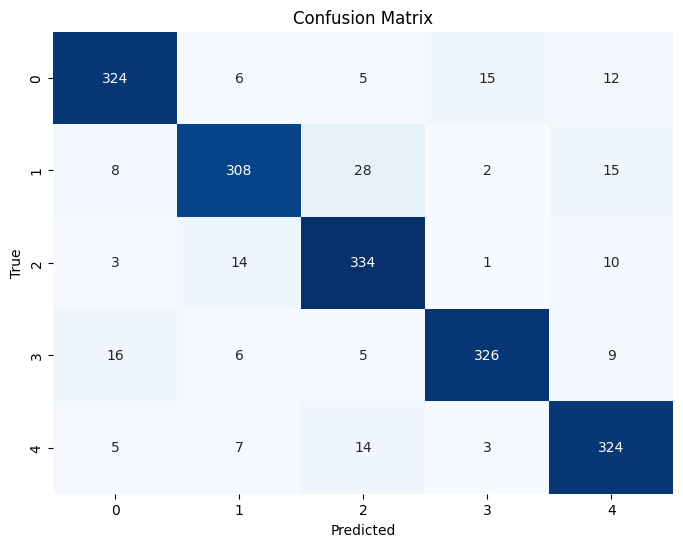

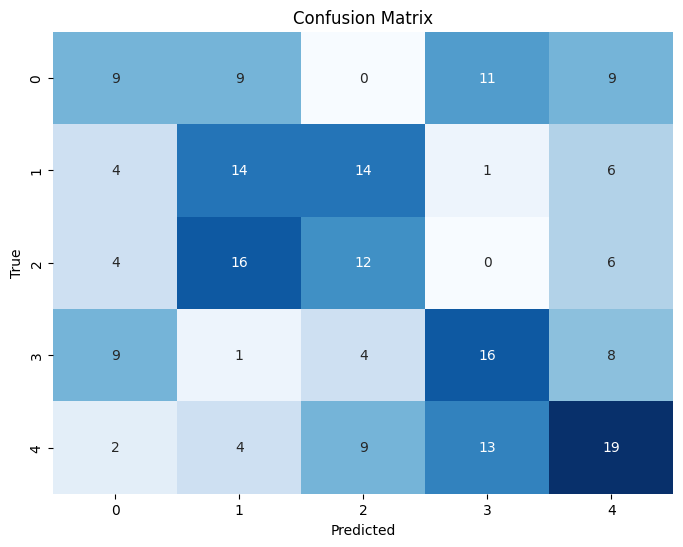

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = svm_classifier.predict(X_test)
# Compute confusion matrix
conf_matrix_val = confusion_matrix(y_test, y_pred)
conf_matrix_train = confusion_matrix(y_train, svm_classifier.predict(X_train))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()